In [15]:
import numpy as np
import torch
from PIL import Image, ImageFont, ImageDraw 
import matplotlib.pyplot as plt
import os

In [16]:
def read_A(path, i):
    path=os.path.join(path, str(i)+'_decoder.pt')
    A = torch.load(path)[1].softmax(-1).squeeze()
    num_nodes = int(np.sqrt(A.size(0)))
    A = A.view(num_nodes, num_nodes, -1).cpu().detach().numpy()
    return num_nodes, A


In [65]:
def draw_background(num_nodes, im_size=400, center_xs=[100, 300]):
    # 255, 255, 255 is white
    texts=["shape", "color", "friction", "theta", "mass", "v_0", "velocity", "position"]
    r = 0.4*im_size/(2+num_nodes)
    im = Image.new('RGB', (im_size, im_size), (255,255,255))
    draw = ImageDraw.Draw(im)
    center_ys = np.linspace(0, im_size, num_nodes+1, endpoint=False)[1:]
    for x in center_xs:
        for i in range(len(center_ys)):  
            y = center_ys[i]
            draw.ellipse((x-r, y-r, x+r, y+r), fill=(255, 255, 0))
            draw.text((x-r,y-r),texts[i], fill=(0,0,0))
    return im, draw, center_ys 


In [57]:
def draw_lines(A, draw, center_ys, center_xs=[100, 300]):
    edge = A.argmax(-1)
    for i in range(len(A)):
        for j in range(len(A[0])):
            if edge[i][j]==1:
                print(A[i][j][1])
                color = 'hsl(%d, %d%%, %d%%)' % (180, (1-A[i][j][1])*100, (1-A[i][j][1])*100)
                draw.line([(center_xs[0], center_ys[j]), (center_xs[1],center_ys[i])],\
                          width=3, fill=color)
    

0.8804715
0.82889795
0.69982076
0.77607983
0.72248304
0.751358


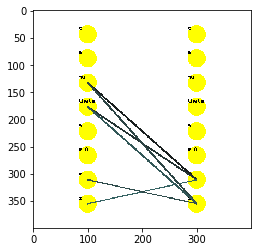

In [63]:
num_nodes, A=read_A(path, 20)
im, draw, center_ys = draw_background(8)
draw_lines(A, draw, center_ys)
plt.imshow(im)

In [23]:
# pos = 0
# images = []
# for i in range(10):
#     frame = im.copy()
#     draw = ImageDraw.Draw(frame)
#     draw.ellipse((pos, pos, 50+pos, 50+pos),
#                  'red')
#     images.append(frame)
#     pos += 10
# images[0].save('./pillow_imagedraw.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

array([  0.        ,  57.14285714, 114.28571429, 171.42857143,
       228.57142857, 285.71428571, 342.85714286, 400.        ])

In [68]:
folder='exp2020-08-11T13:51:41.155358_train-bs_144_suffix_causal_vel_grouped_46656'
path='logs/'+folder
images=[]
for i in np.linspace(0,200,11,dtype=int):
    num_nodes, A=read_A(path, i)
    im, draw, center_ys = draw_background(num_nodes)
    draw_lines(A, draw, center_ys)
    images.append(im)
images[0].save(folder+'_connection.gif',
                save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)

0.54270715
0.52179664
0.55619025
0.52932024
0.505581
0.564859
0.5301114
0.53756183
0.50410086
0.51199985
0.54812163
0.52524024
0.52730995
0.5191061
0.50277716
0.54168266
0.53370786
0.54583335
0.5262317
0.5042182
0.50529176
0.51121265
0.5169163
0.50210065
0.5382779
0.5069423
0.52574706
0.5120955
0.5154713
0.50942457
0.5223811
0.5002366
0.53426117
0.51594454
0.5516667
0.5062522
0.51041514
0.51895535
0.5182699
0.5196324
0.5115767
0.5194031
0.66266817
0.63130796
0.5046667
0.55031145
0.59704465
0.5892492
0.56256574
0.74011403
0.69439214
0.59637713
0.66730124
0.6343581
0.614172
0.7657453
0.71633744
0.615473
0.688552
0.65072864
0.6362235
0.7894982
0.7376776
0.63289726
0.70709944
0.6632935
0.655219
0.7990945
0.746385
0.6395879
0.7127027
0.6684248
0.6633785
0.8077179
0.7539209
0.64721
0.7204226
0.6741056
0.6712847
0.8118116
0.7576158
0.6510531
0.7232101
0.6767245
0.674432
0.81554353
0.76026785
0.6540877
0.72525525
0.67885363
0.6783459
0.81712836
0.76213443
0.65576386
0.7268157
0.6802457
0.68055

In [59]:
from models.modules_causal_vel import *
from data.AL_sampler import RandomPytorchSampler
from data.datasets import *
from data.dataset_utils import *
import argparse
from torch.utils.data import DataLoader
from utils.functions import *

parser = argparse.ArgumentParser()
parser.add_argument("-f",help="Input image, directory, or npy.")
args = parser.parse_args()
args.dims = 9
args.edge_types = 2
args.decoder_hidden = 256
args.skip_first = True
args.decoder_dropout = 0.0
args.self_loop = True
args.suffix = 'valid_causal_vel_interpolation'
args.input_atoms = 6
args.variations = 4
args.train_size = None
args.temp = 0.01
args.hard = True
args.prediction_steps = 19
args.control_constraint = 1.0
args.grouped=False
args.train_bs=1
args.target_atoms =2
args.gt_A=True

args.num_atoms = args.input_atoms+args.target_atoms        
decoder = MLPDecoder_Causal(args).cuda()

if args.grouped:
    assert args.train_bs % args.variations == 0, "Grouping training set requires args.traing-bs integer times of args.variations"

    train_data = load_one_graph_data(
        args.suffix, size=args.train_size, self_loop=args.self_loop, control=True, control_nodes=args.input_atoms, variations=args.variations)
    train_sampler = RandomPytorchSampler(train_data)
    train_data_loader = DataLoader(
        train_data, batch_size=args.train_bs, shuffle=False, sampler=train_sampler)

else:
    train_data = load_one_graph_data(
        args.suffix, size=args.train_size, self_loop=args.self_loop, control=False)
    train_data_loader = DataLoader(
        train_data, batch_size=args.train_bs, shuffle=True)

off_diag = np.ones([args.num_atoms, args.num_atoms])
rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()


Using ground truth A and the softmax result is tensor([[[[10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
       

In [18]:
def denormalize(target, output, train_data):
    for i in range(target.size(1)):
        output[0,i,:,0] = ((output[0,i,:,0]+1)*(train_data.maxs[i]-train_data.mins[i]))/2+train_data.mins[i]
        target[0,i,:,0] = ((target[0,i,:,0]+1)*(train_data.maxs[i]-train_data.mins[i]))/2+train_data.mins[i]
    return target, output

In [19]:
def load_predict(weight_path, stop_ind=10, gt_A=False):
    decoder.load_state_dict(torch.load(weight_path)[0])
    decoder.eval()  
    decoder.rel_graph = torch.load(weight_path)[1].cuda()
    loss=[]
    truth = []
    pred = []
    condition =[]
    for batch_idx, all_data in enumerate(train_data_loader):
        if batch_idx<stop_ind:
            if args.grouped:
                # edge is only for calculating edge accuracy. Since we have not included that, edge is not used.
                data, which_node, edge = all_data[0].cuda(
                ), all_data[1].cuda(), all_data[2].cuda()
                output, logits, msg_hook = decoder(data, rel_rec, rel_send,
                                                   args.temp, args.hard, args.prediction_steps, [])
                control_constraint_loss = control_loss(
                    msg_hook, which_node, args.input_atoms, args.variations)*args.control_constraint
                # if batch_idx == 20:
                #     print('start3', time.time()-start3)

            else:
                data, edge = all_data[0].cuda(), all_data[1].cuda()
                output, logits, msg_hook = decoder(data, rel_rec, rel_send,
                                                   args.temp, args.hard, args.prediction_steps, [])
                control_constraint_loss = torch.zeros(1).cuda()
            print('batch_size', data.size(0))
            target = data[:, :, 1:, :] 
            loss_nll = nll_gaussian(output[:, -2:, :, :], target[:, -2:, :, :], 5e-5)
            print('Nll', loss_nll)
            loss.append(loss_nll.item())
            
            target, output = denormalize(target, output, train_data)
            print('Setup [shapes,colors,mus,thetas,masses,v0s]', batch_idx, target[0,:-2,0,0])
            print('Velocity',batch_idx, target[0,-2,:,0], '\n',output[0,-2,:,0])
            print('Position',batch_idx, target[0,-1,:,0], '\n',output[0,-1,:,0])
            condition.append(target[:,:-2,0,0])
            truth.append(target)
            pred.append(output)
        else:
            print('Avg nll loss', np.mean(loss))
            return loss, truth, pred, condition

In [145]:
loss, truth, pred, condition = load_predict('logs/exp2020-08-11T13:51:13.638329_train-bs_144_grouped_control-constraint_1.0_suffix_causal_vel_grouped_46656/best_decoder.pt')

RuntimeError: Error(s) in loading state_dict for MLPDecoder_Causal:
	size mismatch for msg_fc1.0.weight: copying a param with shape torch.Size([256, 18]) from checkpoint, the shape in current model is torch.Size([256, 16]).
	size mismatch for msg_fc1.1.weight: copying a param with shape torch.Size([256, 18]) from checkpoint, the shape in current model is torch.Size([256, 16]).
	size mismatch for out_fc1.weight: copying a param with shape torch.Size([256, 265]) from checkpoint, the shape in current model is torch.Size([256, 264]).
	size mismatch for out_fc3.weight: copying a param with shape torch.Size([9, 256]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for out_fc3.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([8]).

In [34]:
loss, truth, pred, condition = load_predict('logs/exp2020-08-11T13:51:41.155358_train-bs_144_suffix_causal_vel_grouped_46656/best_decoder.pt')

Nll tensor(4239.6104, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([17.9601, 16.4974,  0.5019,  0.3278,  3.3355,  2.8638], device='cuda:0')
Velocity 0 tensor([  1.3630,  -0.1379,  -1.6388,  -3.1396,  -4.6405,  -6.1413,  -7.6422,
         -9.1430, -10.6439, -12.1447, -13.6456, -15.1464, -16.6473, -18.1481,
        -19.6490, -21.1498, -22.6507, -24.1515], device='cuda:0') 
 tensor([ 2.5133,  2.1512,  1.7773,  1.3915,  0.9938,  0.5841,  0.1623, -0.2715,
        -0.7164, -1.1711, -1.6354, -2.1090, -2.5918, -3.0837, -3.5845, -4.0942,
        -4.6128, -5.1402], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([   2.1134,    2.7259,    1.8375,   -0.5516,   -4.4416,   -9.8326,
         -16.7243,  -25.1169,  -35.0103,  -46.4046,  -59.2998,  -73.6957,
         -89.5926, -106.9903, -125.8889, -146.2883, -168.1885, -191.5897],
       device='cuda:0') 
 tensor([ 1.4555,  2.8860,  4.2957,  5.6892,  7.0689,  8.4366,  9.7972, 11.1503,
      

Nll tensor(1119.7065, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([17.9601, 16.4974,  0.4958,  0.3722,  1.6812,  2.8638], device='cuda:0')
Velocity 8 tensor([  1.9013,   0.9388,  -0.0237,  -0.9862,  -1.9488,  -2.9113,  -3.8738,
         -4.8363,  -5.7988,  -6.7613,  -7.7238,  -8.6863,  -9.6488, -10.6114,
        -11.5739, -12.5364, -13.4989, -14.4614], device='cuda:0') 
 tensor([ 2.4151,  1.9537,  1.4799,  0.9939,  0.4961, -0.0130, -0.5334, -1.0650,
        -1.6079, -2.1619, -2.7265, -3.3017, -3.8869, -4.4824, -5.0893, -5.7069,
        -6.3354, -6.9755], device='cuda:0', grad_fn=<SelectBackward>)
Position 8 tensor([   2.3826,    3.8026,    4.2601,    3.7551,    2.2876,   -0.1425,
          -3.5349,   -7.8900,  -13.2075,  -19.4876,  -26.7301,  -34.9352,
         -44.1028,  -54.2329,  -65.3256,  -77.3806,  -90.3983, -104.3784],
       device='cuda:0') 
 tensor([  -5.3002,  -10.7206,  -16.2416,  -21.8534,  -27.5648,  -33.3758,
         -39

In [20]:
def draw_background(theta, slope_len, im_size=(500,300)):
    #theta in degree
#     theta = theta * np.pi/180
    # 255, 255, 255 is white
    im = Image.new('RGB', im_size, (255,255,255))
    draw = ImageDraw.Draw(im)
    start_x = im_size[0]/5
    start_y = im_size[1]/3
    draw.line([(start_x, start_y), (start_x+slope_len, start_y+slope_len*np.tan(theta))],\
                          width=5, fill=(0,0,0))
    return im, draw, (start_x, start_y)

(100.0, 100.0)


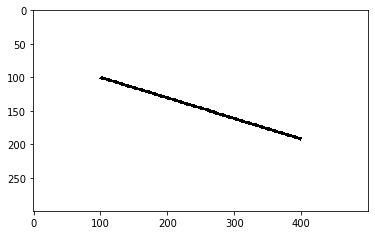

In [21]:
im, draw, start = draw_background(0.3,300)
plt.imshow(im)
print(start)

In [22]:
def draw_trajectory(draw, start, pos, theta, cube_len=30,fill=(255,0,0)):
#     theta = theta * np.pi/180
    cx = start[0]+pos*np.cos(theta)
    cy = start[1]+pos*np.sin(theta)
    cx += np.sin(theta)*cube_len/2
    cy -= np.cos(theta)*cube_len/2
    x_ll = cx-np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ll = cy+np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    x_lr = cx+np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_lr = cy+np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)

    x_ul = cx+np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ul = cy-np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    x_ur = cx-np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ur = cy-np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    draw.polygon([(x_ul, y_ul),(x_lr, y_lr),(x_ll, y_ll),(x_ur, y_ur)],fill=fill)
        

In [23]:
def draw_cube(folder, trajectory, theta, scale=1):
    images=[]
    for i in range(trajectory.shape[1]):
        print(i, trajectory[0][i], trajectory[1][i])
        fig=plt.figure(figsize=(8, 8))         
        pos_1 = trajectory[0][i]*scale                      
        im, draw, start = draw_background(theta,300)
        draw_trajectory(draw, start, pos_1, theta, cube_len=30)
        ax_1= fig.add_subplot(121)
        ax_1.title.set_text('Ground truth')
        plt.imshow(im)
        pos_2 = trajectory[1][i]*scale                          
        im_2, draw, start = draw_background(theta,300)
        draw_trajectory(draw, start, pos_2, theta, cube_len=30)
        ax_2 = fig.add_subplot(122)
        ax_2.title.set_text('Prediction')
        plt.imshow(im_2)                          
        fig.savefig('plot.png') 
        images.append(Image.open('plot.png'))
    images[0].save('_'.join([folder, str(batch_ind), str(datapoint_ind),'cube.gif']),
                    save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)



In [48]:
def draw_cube_stack(folder, trajectory, theta, scale=1, suffix=''):
    images=[]
    for i in range(trajectory.shape[1]):
        print(i, trajectory[0][i], trajectory[1][i])
        fig=plt.figure(figsize=(8, 8))         
        pos_1 = trajectory[0][i]*scale               
        im, draw, start = draw_background(theta,300)
        draw_trajectory(draw, start, pos_1, theta, cube_len=30, fill='hsl(%d, %d%%, %d%%)' % (180,100,50))             
        pos_2 = trajectory[1][i]*scale                 
        draw_trajectory(draw, start, pos_2, theta, cube_len=30, fill='hsl(%d, %d%%, %d%%)' % (0,100,50)) 
        fig.suptitle('Blue ground truth, red prediction.')
        plt.imshow(im)                          
        fig.savefig('plot.png') 
        images.append(Image.open('plot.png'))
    images[0].save('_'.join([folder, suffix, str(batch_ind), str(datapoint_ind),'cube_stack.gif']),
                    save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)




In [106]:
feat = np.load('data/datasets/feat_train_'+args.suffix + '.npy')
feat=feat[:,:,0,0]

In [123]:
x=feat[np.where(feat[:,2] == 10.0000)]
set(x[np.where(x[:,3]>3)][:,0])

{1.0, 2.0, 3.0, 100.0, 200.0}

In [60]:
folder='exp2020-08-14T18:09:03.937011_train-bs_128_suffix_causal_vel_x0s_val-suffix_causal_vel_interpolation_dims_9_input-atoms_6_gt-A'
path='logs/'+folder
loss, truth, pred, condition = load_predict(path+'/best_decoder.pt', stop_ind=50)

batch_size 1
Nll tensor(128.3987, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 5.0000,  2.0000,  0.1800,  0.8491,  2.3000, 12.0000], device='cuda:0')
Velocity 0 tensor([  6.1912,  12.3823,  18.5735,  24.7646,  30.9558,  37.1470,  43.3381,
         49.5293,  55.7204,  61.9116,  68.1027,  74.2939,  80.4851,  86.6762,
         92.8674,  99.0585, 105.2497, 111.4409], device='cuda:0') 
 tensor([  5.9489,  11.9424,  17.9934,  24.0937,  30.2084,  36.3184,  42.4171,
         48.5087,  54.5801,  60.6334,  66.6745,  72.6957,  78.7022,  84.6835,
         90.6848,  96.7244, 102.7800, 108.8084], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 0 tensor([  15.0956,   24.3823,   39.8602,   61.5293,   89.3895,  123.4408,
         163.6834,  210.1171,  262.7419,  321.5579,  386.5651,  457.7634,
         535.1529,  618.7335,  708.5054,  804.4683,  906.6224, 1014.9677],
       device='cuda:0') 
 tensor([ 16.0638,  24.2779,  37.6621,  56.8411,  

batch_size 1
Nll tensor(121.8155, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([ 5.0000,  2.0000,  0.1800,  0.8491,  7.0000, 14.0000], device='cuda:0')
Velocity 8 tensor([  6.1912,  12.3823,  18.5735,  24.7646,  30.9558,  37.1470,  43.3381,
         49.5293,  55.7204,  61.9116,  68.1027,  74.2939,  80.4851,  86.6762,
         92.8674,  99.0585, 105.2497, 111.4409], device='cuda:0') 
 tensor([  5.9489,  11.9424,  17.9934,  24.0937,  30.2084,  36.3184,  42.4171,
         48.5087,  54.5801,  60.6334,  66.6745,  72.6957,  78.7022,  84.6835,
         90.6848,  96.7244, 102.7800, 108.8084], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 8 tensor([  17.0956,   26.3823,   41.8602,   63.5293,   91.3895,  125.4409,
         165.6834,  212.1171,  264.7419,  323.5579,  388.5651,  459.7634,
         537.1529,  620.7335,  710.5053,  806.4683,  908.6224, 1016.9677],
       device='cuda:0') 
 tensor([ 18.0820,  26.3316,  39.7623,  58.9997,  

        158.8651, 179.6510, 201.7779, 225.2458], device='cuda:0') 
 tensor([  9.6125,  12.1780,  15.8921,  20.8617,  27.1609,  34.9134,  44.2371,
         55.1930,  67.8590,  82.2890,  98.5169, 116.5797, 136.5415, 158.3387,
        181.8629, 206.8940, 233.2775, 260.9940], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(14.9247, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 16 tensor([ 7.0000,  6.0000,  0.2600,  0.6981,  7.0000, 14.0000], device='cuda:0')
Velocity 16 tensor([ 4.3474,  8.6949, 13.0423, 17.3897, 21.7372, 26.0846, 30.4321, 34.7795,
        39.1269, 43.4744, 47.8218, 52.1692, 56.5167, 60.8641, 65.2116, 69.5590,
        73.9064, 78.2539], device='cuda:0') 
 tensor([ 4.3463,  8.7022, 13.0673, 17.4428, 21.8189, 26.1905, 30.5504, 34.9090,
        39.2608, 43.6092, 47.9577, 52.3098, 56.6623, 61.0236, 65.3977, 69.7694,
        74.1490, 78.5322], device='cuda:0', grad_fn=<SelectBackward>)
Position 16 tensor([ 16.1737

batch_size 1
Nll tensor(235.5621, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([7.0000, 4.0000, 0.4800, 0.5712, 2.3000, 5.9000], device='cuda:0')
Velocity 23 tensor([ 1.3410,  2.6820,  4.0231,  5.3641,  6.7051,  8.0461,  9.3872, 10.7282,
        12.0692, 13.4102, 14.7513, 16.0923, 17.4333, 18.7743, 20.1154, 21.4564,
        22.7974, 24.1384], device='cuda:0') 
 tensor([ 1.6566,  3.3050,  4.9476,  6.5845,  8.2175,  9.8539, 11.4916, 13.1292,
        14.7672, 16.4047, 18.0435, 19.6851, 21.3294, 22.9788, 24.6339, 26.2960,
        27.9683, 29.6499], device='cuda:0', grad_fn=<SelectBackward>)
Position 23 tensor([  6.5705,   8.5821,  11.9346,  16.6282,  22.6628,  30.0384,  38.7551,
         48.8128,  60.2115,  72.9512,  87.0319, 102.4537, 119.2165, 137.3203,
        156.7651, 177.5510, 199.6779, 223.1458], device='cuda:0') 
 tensor([  7.5028,  10.0438,  13.7233,  18.6558,  24.9092,  32.6138,  41.8835,
         52.7792,  65.3829,  79.7484,  95.

       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(9.2853, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 31 tensor([5.0000, 4.0000, 0.5000, 1.1636, 7.0000, 8.0000], device='cuda:0')
Velocity 31 tensor([  7.0577,  14.1155,  21.1732,  28.2309,  35.2886,  42.3464,  49.4041,
         56.4618,  63.5195,  70.5773,  77.6350,  84.6927,  91.7505,  98.8082,
        105.8659, 112.9236, 119.9814, 127.0391], device='cuda:0') 
 tensor([  6.9762,  14.0172,  21.1092,  28.2438,  35.4065,  42.5770,  49.7427,
         56.9042,  64.0433,  71.1507,  78.2159,  85.2671,  92.3060,  99.3183,
        106.3246, 113.3481, 120.3343, 127.2347], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 31 tensor([  11.5289,   22.1155,   39.7598,   64.4618,   96.2216,  135.0391,
         180.9143,  233.8473,  293.8379,  360.8864,  434.9925,  516.1564,
         604.3779,  699.6573,  801.9943,  911.3890, 1027.8417, 1151.3518],
       device='cuda:0') 
 tensor([  13.1062,   

batch_size 1
Nll tensor(174.6642, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 38 tensor([7.0000, 6.0000, 0.4800, 0.6981, 2.7000, 5.9000], device='cuda:0')
Velocity 38 tensor([ 2.6958,  5.3917,  8.0875, 10.7834, 13.4792, 16.1751, 18.8709, 21.5668,
        24.2626, 26.9585, 29.6543, 32.3501, 35.0460, 37.7418, 40.4377, 43.1335,
        45.8294, 48.5252], device='cuda:0') 
 tensor([ 2.9248,  5.8632,  8.8150, 11.7819, 14.7566, 17.7327, 20.7098, 23.6877,
        26.6676, 29.6496, 32.6315, 35.6065, 38.5721, 41.5269, 44.4801, 47.4360,
        50.3955, 53.3634], device='cuda:0', grad_fn=<SelectBackward>)
Position 38 tensor([  7.2479,  11.2917,  18.0313,  27.4668,  39.5981,  54.4252,  71.9482,
         92.1671, 115.0818, 140.6923, 168.9987, 200.0009, 233.6990, 270.0929,
        309.1826, 350.9682, 395.4497, 442.6270], device='cuda:0') 
 tensor([  8.2563,  12.4179,  18.9221,  28.1387,  40.1744,  55.1082,  73.1077,
         94.2441, 118.5841, 146.0571, 176.

batch_size 1
Nll tensor(8.7616, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 46 tensor([ 7.0000,  6.0000,  0.5000,  1.1636,  2.3000, 12.0000], device='cuda:0')
Velocity 46 tensor([  7.0577,  14.1155,  21.1732,  28.2309,  35.2886,  42.3464,  49.4041,
         56.4618,  63.5195,  70.5773,  77.6350,  84.6927,  91.7505,  98.8082,
        105.8659, 112.9236, 119.9814, 127.0391], device='cuda:0') 
 tensor([  6.9762,  14.0172,  21.1092,  28.2438,  35.4065,  42.5770,  49.7427,
         56.9042,  64.0433,  71.1507,  78.2159,  85.2671,  92.3060,  99.3183,
        106.3246, 113.3481, 120.3343, 127.2347], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 46 tensor([  15.5288,   26.1154,   43.7598,   68.4618,  100.2216,  139.0391,
         184.9143,  237.8473,  297.8380,  364.8864,  438.9925,  520.1564,
         608.3779,  703.6572,  805.9943,  915.3890, 1031.8416, 1155.3518],
       device='cuda:0') 
 tensor([  17.1251,   27.4093,   43.8361,   67.51

0 11.095585 12.027228
1 20.382301 20.170301
2 35.860214 33.461384
3 57.52928 52.526546
4 85.389465 78.02916
5 119.44085 110.20949
6 159.6834 148.90375
7 206.1171 193.47974
8 258.7419 243.66779
9 317.55792 299.93274
10 382.5651 362.47156
11 453.7634 430.98895
12 531.1529 505.25464
13 614.7335 585.69055
14 704.5053 672.8243
15 800.4683 765.9862
16 902.62244 864.21246
17 1010.96765 966.8489


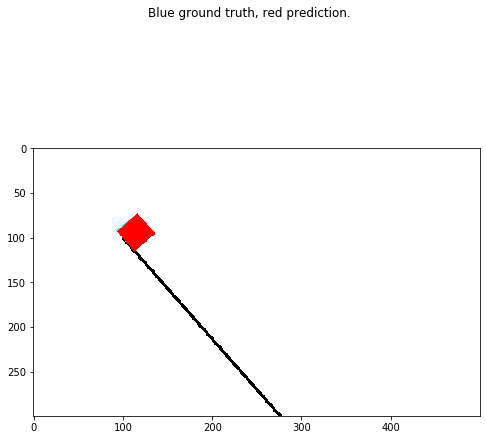

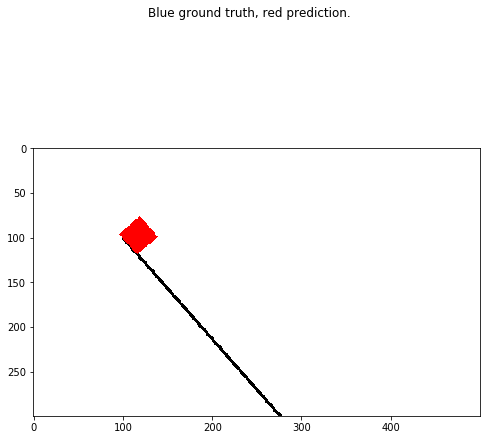

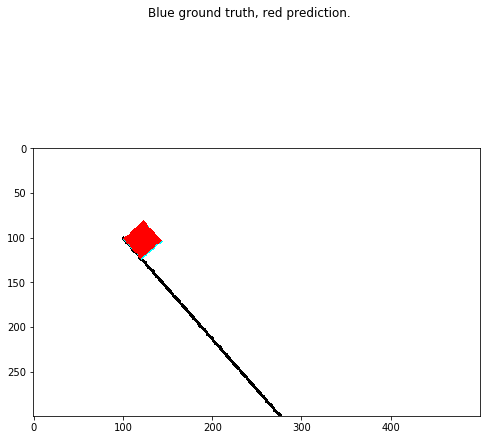

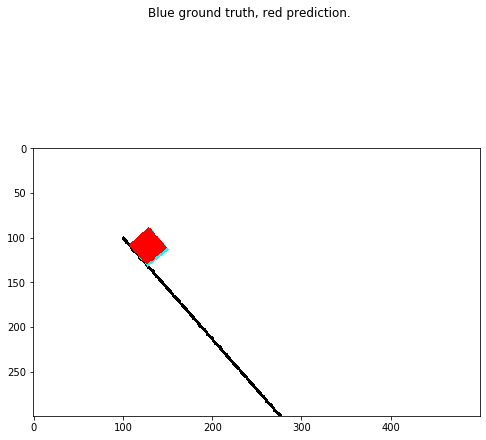

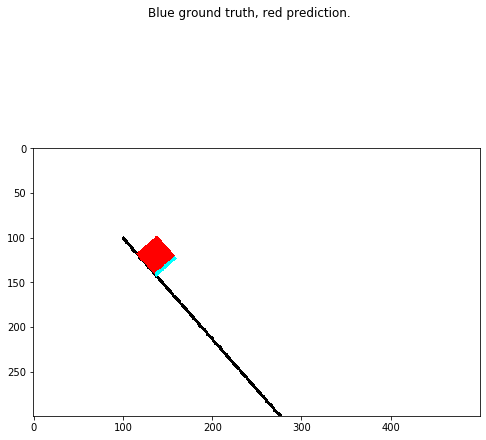

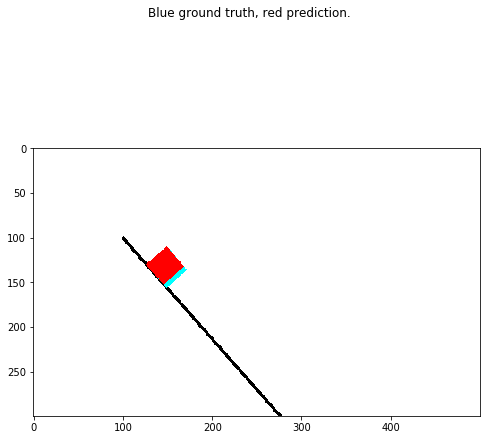

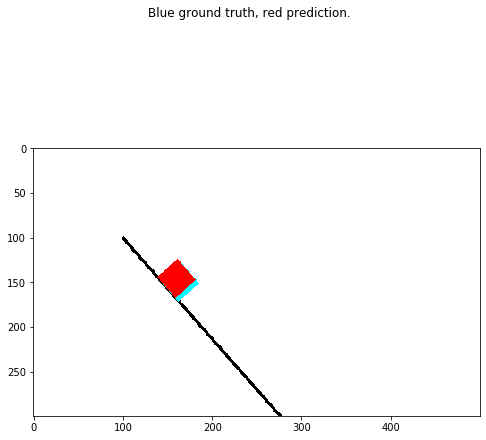

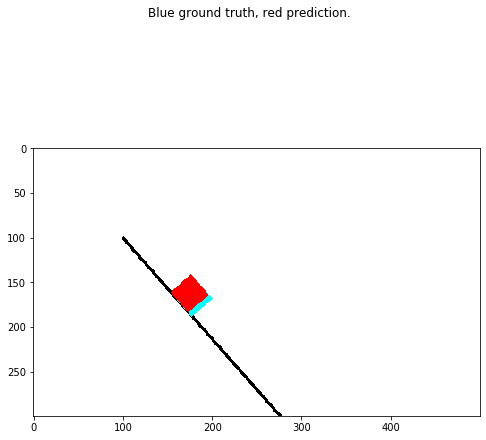

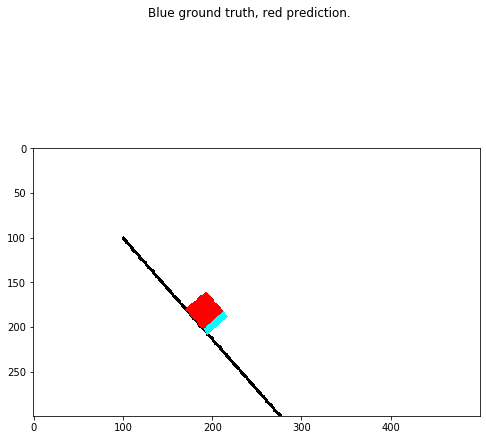

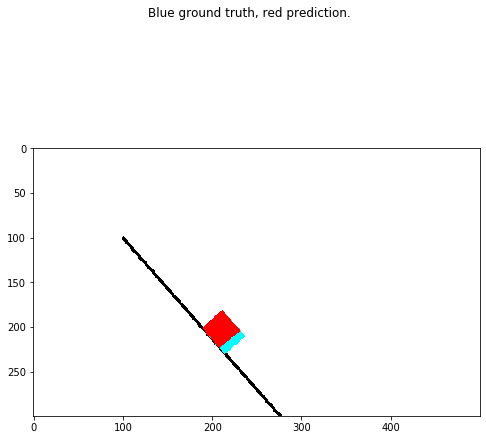

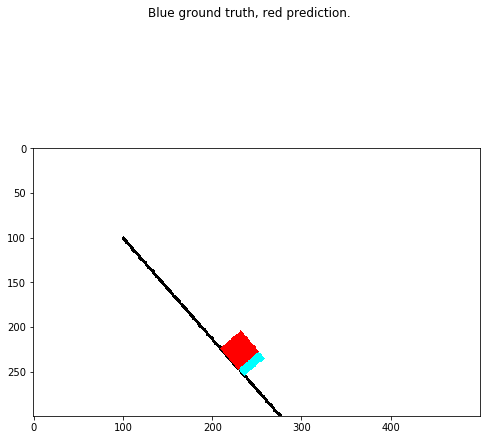

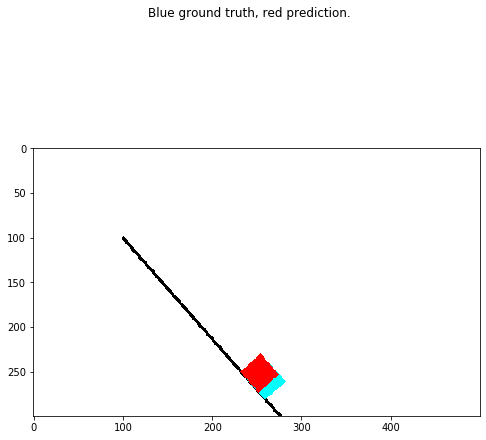

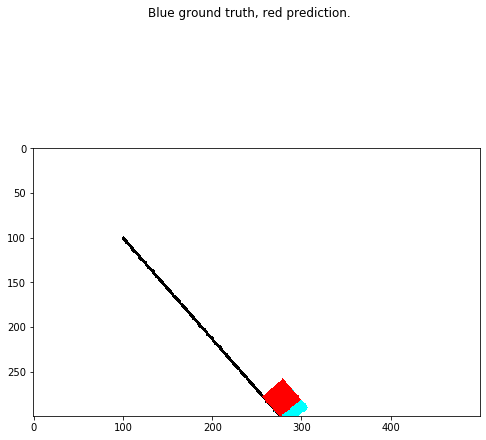

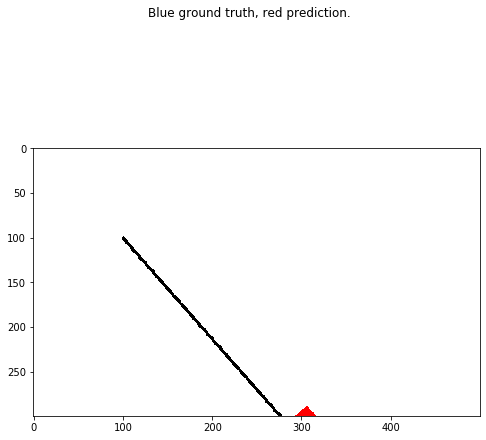

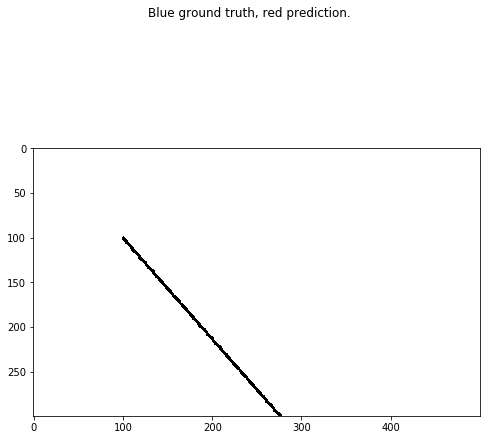

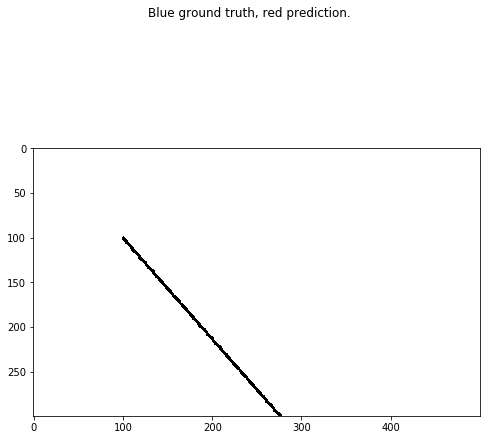

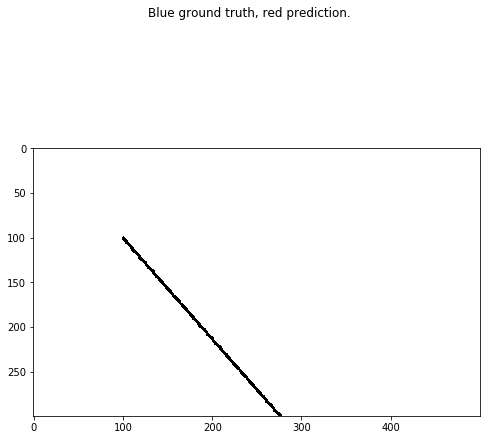

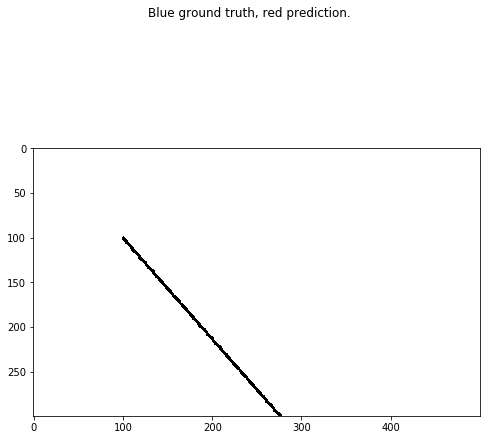

In [61]:
batch_ind = 28
datapoint_ind = 0
trajectory=np.array([truth[batch_ind][datapoint_ind, -1, :, 0].detach().cpu().numpy(),pred[batch_ind][datapoint_ind, -1, :, 0].detach().cpu().numpy()])
theta=condition[batch_ind][datapoint_ind][3].item()
# draw_cube(folder, trajectory, theta)
draw_cube_stack(folder, trajectory, theta, suffix='interpolation',scale=0.5)

In [43]:
x =  np.load('data/datasets/feat_train_causal_vel_x0s.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{1.0, 2.0, 3.0, 6.0, 9.0, 10.0}
{1.0, 3.0, 5.0, 7.0, 9.0, 11.0}
{0.3, 0.56, 0.1, 0.22, 0.28, 0.01}
{0.7853981633974483, 1.0471975511965976, 0.9817477042468103, 1.2566370614359172, 0.6283185307179586, 0.5235987755982988}
{2.0, 3.5, 5.0, 8.0, 9.0, 10.0}
4.0
3.0
3.2
2.5
5.0
6.0


In [45]:
y =  np.load('data/datasets/feat_valid_causal_vel_interpolation.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(y[:,i,0,0]))
for i in set(y[:,3,0,0]):
    print(np.pi/i)

{8.0, 4.0, 5.0, 7.0}
{8.0, 2.0, 4.0, 6.0}
{0.18, 0.26, 0.48, 0.5}
{0.8490790955648089, 0.6981317007977318, 1.1635528346628863, 0.5711986642890533}
{2.7, 3.6, 2.3, 7.0}
3.7
4.5
2.7
5.5


In [37]:
x =  np.load('data/datasets/feat_train_causal_vel_grouped_46656_x0s.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{0.2945703805744371, 2.1746018390150246, 4.709178831461223, 10.707323896632925, 17.90109133492352, 18.443241651557855}
{6.444157225960378, 6.473557830761198, 8.422289279168496, 9.708923257605571, 13.304413652313778, 17.987940431277146}
{0.03236727517783888, 0.5424096630692735, 0.38226477515080215, 0.8029196095360561, 0.05515940346945036, 0.21097059217164793}
{0.1778569832714908, 1.2785271587503566, 0.17722706684139167, 0.4114338900496611, 0.018927094208086193, 1.3492917908739654}
{1.6351224561247935, 4.562630947312978, 6.015489417044664, 18.428300115083104, 19.78184679271364, 19.748196643271065}
17.663589001699705
2.457196651700706
17.726370523309193
7.635716769006548
165.98388632987388
2.328327108219428


In [38]:
x =  np.load('data/datasets/feat_valid_causal_vel_grouped_46656_x0s.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{16.397163938436826, 8.264018696323616, 16.475188651410427, 17.52535310413255}
{16.04341124848951, 1.0894901564470927, 14.372744731283886, 14.728132876228779}
{0.8928601514360016, 0.3319798053011772, 0.8212291230578318, 0.0416966257252499}
{0.16148501990395192, 0.8925780963093604, 0.7947260432892325, 0.6282111428349815}
{8.762828522177482, 12.450388643921803, 6.708156985466585, 14.717642126973804}
19.45439060204067
3.519683786303605
3.9530510924082582
5.000854711701646


In [30]:
folder='exp2020-08-15T22:33:50.224932_train-bs_128_suffix_causal_vel_x0s_more_val-suffix_causal_vel_interpolation_gt-A_dims_9_input-atoms_6'
path='logs/'+folder
loss, truth, pred, condition = load_predict(path+'/best_decoder.pt', stop_ind=50)

batch_size 1
Nll tensor(10691.9531, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([10.0000,  1.0000,  0.6500,  1.4280,  1.0000,  2.0000], device='cuda:0')
Velocity 0 tensor([  8.7937,  17.5874,  26.3811,  35.1748,  43.9685,  52.7622,  61.5559,
         70.3496,  79.1433,  87.9370,  96.7308, 105.5244, 114.3181, 123.1119,
        131.9056, 140.6993, 149.4930, 158.2867], device='cuda:0') 
 tensor([  6.0115,  12.0341,  18.0552,  24.0750,  30.0732,  36.0185,  41.9079,
         47.7677,  53.6366,  59.5324,  65.4754,  71.4799,  77.5415,  83.6474,
         89.8177,  96.0596, 102.3768, 108.7521], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 0 tensor([   6.3969,   19.5874,   41.5717,   72.3497,  111.9213,  160.2867,
         217.4458,  283.3985,  358.1450,  441.6852,  534.0191,  635.1467,
         745.0680,  863.7830,  991.2917, 1127.5941, 1272.6903, 1426.5802],
       device='cuda:0') 
 tensor([  16.6206,   36.0990,   61.4060,   93.2

batch_size 1
Nll tensor(1237.2451, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([ 1.0000,  1.0000,  0.6500,  0.4987, 11.0000, 23.0000], device='cuda:0')
Velocity 8 tensor([ -0.9074,  -1.8148,  -2.7221,  -3.6295,  -4.5369,  -5.4443,  -6.3517,
         -7.2591,  -8.1664,  -9.0738,  -9.9812, -10.8886, -11.7960, -12.7034,
        -13.6107, -14.5181, -15.4255, -16.3329], device='cuda:0') 
 tensor([ -0.5506,  -1.1159,  -1.6958,  -2.2896,  -2.8969,  -3.5184,  -4.1536,
         -4.8017,  -5.4626,  -6.1366,  -6.8235,  -7.5239,  -8.2369,  -8.9623,
         -9.7002, -10.4506, -11.2136, -11.9893], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 8 tensor([  22.5463,   21.1852,   18.9168,   15.7410,   11.6577,    6.6671,
           0.7691,   -6.0363,  -13.7490,  -22.3691,  -31.8966,  -42.3316,
         -53.6738,  -65.9235,  -79.0805,  -93.1449, -108.1168, -123.9960],
       device='cuda:0') 
 tensor([ 23.4080,  23.4976,  23.2710,  22.7199, 

       grad_fn=<SelectBackward>)
Position 15 tensor([   6.9000,   21.6000,   46.1000,   80.4000,  124.5000,  178.4000,
         242.1000,  315.6000,  398.9000,  491.9999,  594.9000,  707.6000,
         830.1000,  962.4000, 1104.5000, 1256.4000, 1418.1000, 1589.6000],
       device='cuda:0') 
 tensor([  17.1039,   39.1605,   70.7656,  113.2485,  166.9958,  232.4138,
         309.7836,  398.1749,  498.3140,  609.7523,  731.8871,  864.5025,
        1007.5696, 1161.0532, 1323.1835, 1488.3313, 1651.6237, 1810.1699],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(4126.7295, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 16 tensor([1.0000e+00, 5.0000e+00, 9.9999e-04, 1.4280e+00, 1.1000e+01, 2.0000e+00],
       device='cuda:0')
Velocity 16 tensor([  9.6989,  19.3977,  29.0966,  38.7954,  48.4943,  58.1931,  67.8920,
         77.5908,  87.2897,  96.9885, 106.6874, 116.3863, 126.0851, 135.7840,
        145.4828, 155.1817, 164.8805,

       device='cuda:0') 
 tensor([  0.5327,   0.7484,   0.6506,   0.2325,  -0.5131,  -1.5853,  -2.9936,
         -4.7354,  -6.8144,  -9.2018, -11.8854, -14.8592, -18.1079, -21.6242,
        -25.4098, -29.4704, -33.7994, -38.3964], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(3790.3040, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([3.0000e+00, 3.0000e+00, 5.0000e-03, 1.5708e+00, 1.4000e+01, 5.0000e-01],
       device='cuda:0')
Velocity 23 tensor([  9.8000,  19.6000,  29.4000,  39.2000,  49.0000,  58.8000,  68.6000,
         78.4000,  88.2000,  98.0000, 107.8000, 117.6000, 127.4000, 137.2000,
        147.0000, 156.8000, 166.6000, 176.4000], device='cuda:0') 
 tensor([  8.8793,  17.8198,  26.8183,  35.9111,  45.1317,  54.5175,  64.0618,
         73.7293,  83.4874,  93.3562, 103.3481, 113.5335, 123.8823, 134.3536,
        144.9086, 155.5385, 166.0821, 176.4561], device='cuda:0',
       grad_fn=<SelectBackward>)


batch_size 1
Nll tensor(4585.1943, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 30 tensor([1.0000e+00, 1.0000e+00, 9.9999e-04, 1.4280e+00, 1.4000e+01, 2.3000e+01],
       device='cuda:0')
Velocity 30 tensor([  9.6989,  19.3977,  29.0966,  38.7954,  48.4943,  58.1931,  67.8920,
         77.5908,  87.2897,  96.9885, 106.6874, 116.3863, 126.0851, 135.7840,
        145.4828, 155.1817, 164.8805, 174.5794], device='cuda:0') 
 tensor([  8.5356,  17.1222,  25.7744,  34.5243,  43.4037,  52.4096,  61.5143,
         70.7338,  80.0489,  89.5097,  99.1262, 108.8937, 118.8193, 128.8447,
        138.9294, 149.0573, 159.1582, 169.1223], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 30 tensor([  27.8494,   42.3977,   66.6449,  100.5908,  144.2357,  197.5794,
         260.6219,  333.3634,  415.8036,  507.9427,  609.7807,  721.3176,
         842.5533,  973.4879, 1114.1212, 1264.4535, 1424.4845, 1594.2145],
       device='cuda:0') 
 tensor([  39.8483,  

Nll tensor(3536.1455, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 37 tensor([3.0000e+00, 5.0000e+00, 5.0000e-03, 5.1502e-01, 1.0000e+00, 5.0000e-01],
       device='cuda:0')
Velocity 37 tensor([ 4.7843,  9.5687, 14.3530, 19.1373, 23.9216, 28.7060, 33.4903, 38.2746,
        43.0589, 47.8433, 52.6276, 57.4119, 62.1963, 66.9806, 71.7649, 76.5492,
        81.3336, 86.1179], device='cuda:0') 
 tensor([ 3.6041,  7.2113, 10.8143, 14.4197, 18.0326, 21.6499, 25.2773, 28.9250,
        32.5815, 36.2393, 39.8981, 43.5583, 47.2167, 50.8731, 54.5210, 58.1637,
        61.8006, 65.4175], device='cuda:0', grad_fn=<SelectBackward>)
Position 37 tensor([  2.8921,  10.0686,  22.0295,  38.7746,  60.3041,  86.6179, 117.7160,
        153.5985, 194.2652, 239.7164, 289.9518, 344.9715, 404.7756, 469.3641,
        538.7368, 612.8939, 691.8353, 775.5609], device='cuda:0') 
 tensor([ 11.4000,  25.0410,  41.6816,  61.7808,  85.6834, 113.4747, 145.3488,
        181.4412, 221.7

batch_size 1
Nll tensor(1131.2798, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 45 tensor([1.0000, 7.0000, 0.6000, 0.4987, 1.0000, 0.0000], device='cuda:0')
Velocity 45 tensor([-0.4771, -0.9541, -1.4312, -1.9082, -2.3853, -2.8623, -3.3394, -3.8164,
        -4.2935, -4.7705, -5.2476, -5.7246, -6.2017, -6.6788, -7.1558, -7.6329,
        -8.1099, -8.5870], device='cuda:0') 
 tensor([-0.3520, -0.7245, -1.1174, -1.5290, -1.9583, -2.4052, -2.8692, -3.3486,
        -3.8424, -4.3497, -4.8701, -5.4041, -5.9511, -6.5109, -7.0837, -7.6696,
        -8.2684, -8.8801], device='cuda:0', grad_fn=<SelectBackward>)
Position 45 tensor([ -0.2385,  -0.9541,  -2.1467,  -3.8164,  -5.9632,  -8.5870, -11.6879,
        -15.2657, -19.3207, -23.8527, -28.8618, -34.3479, -40.3110, -46.7513,
        -53.6686, -61.0629, -68.9343, -77.2827], device='cuda:0') 
 tensor([ 2.0694,  3.8924,  5.4621,  6.7816,  7.8494,  8.6621,  9.2182,  9.5119,
         9.5313,  9.2688,  8.7195,  7.8

2.4000000953674316